# c-GAN

In [327]:
import torch
import torch.nn as nn
from torch.nn import init
import torchsummary
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import math
import os


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Dataset

In [328]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

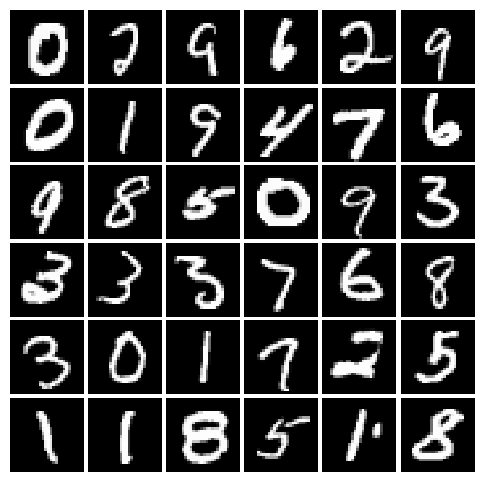

In [329]:
batch_size = 128
mnist_train = dset.MNIST('../datasets', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
imgs = next(loader_train.__iter__())[0].view(batch_size, 784)
show_images(imgs[:36])

## VAE Encoder

Now lets start building our fully-connected VAE network.
Start with the encoder,
which will take our images as input and pass them through a three Linear+ReLU layers.
You will use the output of these layers to predict both the posterior mu and posterior log-variance using two separate linear layers (both shape (N,Z)). 


Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. Architecture for the encoder is described below:

 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`

Complete the `Encoder` class by completing the `self.__init__` and `self.forward` methods.  

In [289]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super().__init__()

        # ==== BEGIN SOLUTION CODE ====        
        self._encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_size, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU()
        )
        # ==== END SOLUTION CODE ====

    def forward(self, x):
        '''
        Use the self._encoder to encode the image to the hidden dimension
        
        Inputs:
        - x: Tensor of shape (N, 1, H, W ) where H * W = input_size

        Returns:
        - h: Tensor of shape (N , hidden_dim)
        '''
        h = None
        # ==== BEGIN SOLUTION CODE ====
        h = self._encoder(x)
        # ==== END SOLUTION CODE ====
        return h

*Implement* a sanity check in the following cell to run a `(32, 1, 28, 28)` random tensor through an encoder initialized with size `786` and `96` dim hidden dimension. The output should be `(32, 96)`. 

In [290]:
# ==== BEGIN SOLUTION CODE ====
encoder = Encoder(input_size=784, hidden_dim=96)
input = torch.rand(32, 1, 28, 28)
print(input.size())
output = encoder(input)
print(output.size())
# ==== END SOLUTION CODE ====

torch.Size([32, 1, 28, 28])
torch.Size([32, 96])


## VAE Decoder

**Implement** the Decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 

 * Fully connected layer with input size as the latent size (Z) and output size hidden dim (H)
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size H
 * `ReLU`
 * Fully connected layer with input_size H and output size (`output_size` = 784)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten: shape=(1,28,28))

Use `nn.Sequential` to define the architecture in `self._decoder`. 

Complete the `Decoder` class by completing the `self.__init__` and `self.forward` methods.  


In [291]:
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_dim, height=28, width=28):
        super().__init__()
        self._decoder = None
        self.latent_size = latent_size
        self.hidden_dim = hidden_dim
        self.height = height
        self.width = width
        self.output_size = height * width

        # ==== BEGIN SOLUTION CODE ==== 
        self._decoder = nn.Sequential(
          nn.Linear(latent_size, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, self.output_size),
          nn.Sigmoid(),
          nn.Unflatten(1, (1, self.height, self.width))
        )
        # ==== END SOLUTION CODE ====


    def forward(self, z):
        """
        Use the self._decoder to reconstruct the image
        
        Inputs:
        - Z: Tensor of shape (N, Z) giving the latent vector

        Returns:
        - x_reconstructed: Reconstruced input data of shape (N,1,H,W)
          whete, H is self.height, and W is self.width
        """
        x_reconstructed = None

        # ==== BEGIN SOLUTION CODE ====
        x_reconstructed = self._decoder(z)
        # ==== END SOLUTION CODE ====
        return x_reconstructed    


*Implement* a sanity check in the following cell to run a `(16, 32)` random tensor through a decoder initialized with a `32` and `96` dim latent space and hidden dimension respectively. The output should be `(16, 1, 28, 28)`

In [292]:
# ==== BEGIN SOLUTION CODE ====
decoder = Decoder(latent_size=32, hidden_dim=96)
input = torch.rand(16, 32)
print(input.size())
output = decoder(input)
print(output.size())
# ==== END SOLUTION CODE ====

torch.Size([16, 32])
torch.Size([16, 1, 28, 28])


## Reparameterization Trick

Apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $log(\sigma^2)$ estimated by the encoder.

In order to be able to backprop through the probabilistic latent space, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\log(\sigma^2)$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then it's easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.

Not that the encoder outputs $\log(\sigma^2))$. So you will need to transform the output first before applying the reparameterization trick. 


**Implement** the reparametrize function.

In [ ]:
def reparameterize(mu, logvar):
    """
    Differentiably sample random Gaussian data with specified mean and variance
    using the reparameterization trick.

    We want to sample a random number z from a Gaussian distribution with
    mean mu and standard deviation sigma, such that we can backpropagate from the
    z back to mu and sigma. We can achieve this by first sampling a random value
    epsilon from a standard Gaussian distribution with zero mean and unit variance,
    then setting z = sigma * epsilon + mu.

    For more stable training when integrating this function into a neural network,
    it helps to pass this function the log of the variance of the distribution from
    which to sample, rather than specifying the standard deviation directly.

    Inputs:
    - mu: Tensor of shape (N, Z) giving means
    - logvar: Tensor of shape (N, Z) giving log-variances

    Returns:
    - z: Estimated latent vectors, where z[i, j] is a random value sampled from a
      Gaussian with mean mu[i, j] and log-variance logvar[i, j].
    """
    z = None
    # ==== BEGIN SOLUTION CODE ====
    epsilon = torch.randn_like(logvar)
    sigma = torch.exp(logvar / 2)
    z = mu + sigma * epsilon
    # ==== END SOLUTION CODE ====
    
    return z

## VAE Model



**Implement** the following cell and complete the implementation of the VAE class. You will need to complete the `self.__init__`, and `self.forward` methods. 

To complete the `self.__init__` method: 
- Define self.encoder which should be a network that
inputs a batch of input images of shape (N, 1, H, W) into a batch of hidden features of shape (N, H_d). Use the `Encoder` class you defined before. 

- Set up self.mu_layer and self.logvar_layer to be a pair of linear layers that map the hidden features into estimates of the mean and log-variance of the posterior over the latent vectors; the mean and log-variance estimates will both be tensors of shape (N, Z). 
Note that we are calling this the 'logvar' layer because we'll use the log-variance (instead of variance or standard deviation) to stabilize training. This will specifically matter more when you compute reparametrization and the loss function. 

- Define self.decoder which should be a network that inputs a batch of latent vectors of shape (N, Z) and outputs a tensor of estimated images of shape (N, 1, H, W). Use the `Decoder` class you defined before. 

To complete the `self.forward` method:

- Get the hidden dimension vector by calling passing the input through the encoder

- Use `self.mu_layer` and `self.logvag_layer` to obtain the posterior mu and logvar

- Use the `reparameterize` function to compute the latent vector z

- Use the decoder to reconstruct the input 

- Return the reconstructed input, the posterior mean, and the posterior logvar. 

In [ ]:
class VAE(nn.Module):
    def __init__(self, height, width, hidden_dim=96, latent_size=16):
        super(VAE, self).__init__()
        self.height = height
        self.width = width
        self.input_size = height * width  # H*W
        self.latent_size = latent_size  # Z
        self.hidden_dim = hidden_dim  
        self.encoder = None
        self.mu_layer = None
        self.logvar_layer = None
        self.decoder = None

        # ==== BEGIN SOLUTION CODE ====
        self.encoder = Encoder(self.input_size, self.hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, self.latent_size)
        self.logvar_layer = nn.Linear(hidden_dim, self.latent_size)
        self.decoder = Decoder(self.latent_size, self.hidden_dim)
        # ==== END SOLUTION CODE ====
        

    def forward(self, x):
        """
        Performs forward pass through VAE model by passing image through
        encoder, reparametrize trick, and decoder models

        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)

        Returns:
        - x_hat: Reconstruced input data of shape (N,1,H,W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent
          space dimension
        - logvar: Matrix representing estimataed variance in log-space (N, Z),
          with Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None
        # ==== BEGIN SOLUTION CODE ====
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        # ==== END SOLUTION CODE ====
        return x_hat, mu, logvar

## VAE Loss

Before we're able to train our final model, we'll need to define our loss function. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

$$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$$

Note that this is the negative of the variational lowerbound shown in lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy` but choose the correct reduction). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{Z} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j})$$

**Implement** this loss that also operates on minibatches.
You should average the loss across samples in the minibatch.



In [ ]:
def VAE_Loss(x, x_reconstructed, mu, logvar):
  loss = None
  # ==== BEGIN SOLUTION CODE ====
  reconstruction_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
  kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  loss = (reconstruction_loss + kl_divergence_loss)
  # ==== END SOLUTION CODE ====
  return loss / 128

## VAE Training

In the following cell, define a VAE and train on the training set. 

The VAE training algorithm is as follows:

1. Instantiate a `VAE` 
    - Suggested: hidden_dim = 96, latent_dim = 16
2. Define a vae optimizer
    - Suggested: ADAM with lr .001
3. For each batch of data;
    - Pass the input through the VAE to get the reconstructed input, the mean and log-var approximate of the posterior
    - Calculate the loss using the `VAE_Loss` 
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

4. Repeat 3, `num_epoch` times
    - Suggested: 10 times. 

*Following the suggested hyper-parameters, training takes approximately 2 minutes.* 

In [ ]:
# ==== BEGIN SOLUTION CODE ====
vae = VAE(height=28, width=28)
num_epochs = 10
learning_rate = 0.001
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
vae.train()
for epoch in range(num_epochs):
  for _,train_batch in enumerate(loader_train):
    train_batch = train_batch[0]
    x_out, mu, logvar = vae(train_batch)
    loss = VAE_Loss(train_batch, x_out, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
# ==== END SOLUTION CODE ====

## Latent Interpolation and Visualization


### Generated Image Visualization

**Implement** the following cell to generate 36 random samples from your previously trained VAE model and visualize the outputs. 

In [ ]:
# ==== BEGIN SOLUTION CODE ====
generated_images = torch.Tensor()
for i in range(36):
  img = loader_train.dataset[i][0].unsqueeze(0)
  vae.eval()
  z = torch.normal(0, 1, size=(1, 16))
  with torch.no_grad():
      generated_image  = vae.decoder(z).view(1, 784)
  generated_images = torch.cat((generated_images, generated_image), 0)
show_images(generated_images)
# ==== END SOLUTION CODE ====

### Latent Interpolation

**Implement** the following cell to perform interpolation in latent space. Generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; run each interpolated vector through the trained decoder to produce an image.

$$
z_{\mathrm{interpolate}} = r_1*z_1 + (1-r_2)*z_2
$$

Take 10 uniformly spaced samples for $r_1$ and $r_2$ in the range [0,1]. 

Each row of the figure should interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

You should use the helper plotting function. You should have a 10x10 grid of images. 

In [ ]:
# ==== BEGIN SOLUTION CODE ====
n = 10
range = (0.0, 1.0)
z1 = torch.normal(0, 1, size=(1, 16))
z2 = torch.normal(0, 1, size=(1, 16))
r1_samples = np.linspace(*range, num=n)
r2_samples = np.linspace(*range, num=n)
plt.figure(figsize=(20,8.5))
w = 28
img = np.zeros((n*w, n*w))
for i, r1 in enumerate(r1_samples):
    for j, r2 in enumerate(r2_samples):
        z_interpolate = torch.mul(z1, r1) + torch.mul(z2, 1 - r2)
        with torch.no_grad():
          generated_image = vae.decoder(z_interpolate).view(28, 28)
        img[(n - 1 - i) * w : (n - 1 - i + 1) * w, j * w : (j + 1) * w] = generated_image
plt.imshow(img, extent=[*range, *range], cmap='gist_gray')
# ==== END SOLUTION CODE ====

# Generative Autoencoder

## Discriminator

In [330]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding_layer = nn.Embedding(10, 10)
    self.linear_layer = nn.Linear(10, 28 * 28 * 1)
    self.width = 28
    self.height = 28
    self.layers = nn.Sequential(
      nn.Unflatten(1, (1, self.height * 2, self.width)),
      nn.Conv2d(1, 32, 5),
      nn.LeakyReLU(negative_slope=0.01),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(32, 64, 5),
      nn.LeakyReLU(negative_slope=0.01),
      nn.MaxPool2d(2, stride=2),
      nn.Flatten(),
      nn.Linear(11 * 4 * 64, 11 * 4 * 64),
      nn.LeakyReLU(negative_slope=0.01),
      nn.Linear(11 * 4 * 64, 1)
    )

  def forward(self, input_distribution, labels):
    logits = None
    labels = self.embedding_layer(labels)
    labels = self.linear_layer(labels)
    input_distribution = torch.cat([input_distribution, labels], 1)
    logits = self.layers(input_distribution)
    return logits  

Input a random sample with shape `(32, 784)` to a discriminator and check if the output is `(32,1)`. 

In [331]:
labels = torch.LongTensor(np.random.randint(0, 10, 32))
discriminator = Discriminator()
input = torch.rand(32, 784)
output = discriminator(input, labels)
print(input.size())
print(output.size())

torch.Size([32, 784])
torch.Size([32, 1])


## Generator

In [332]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(10, 10)
        self.layers = nn.Sequential(
          nn.Linear(noise_dim + 10, 1024),
          nn.ReLU(),
          nn.BatchNorm1d(1024),
          nn.Linear(1024, 7 * 7 * 128),
          nn.ReLU(),
          nn.BatchNorm1d(7 * 7 * 128),
          nn.Unflatten(1, (128, 7, 7)),
          nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
          nn.Tanh(),
          nn.Flatten()
        )

    def forward(self, random_noise, labels):
        fake_image = None
        labels = self.embedding_layer(labels)
        random_noise = torch.cat([random_noise, labels], 1)
        fake_image = self.layers(random_noise)
        return fake_image

Input a random sample with shape `(32, 96)` to a Generator and check if the output is `(32, 784)`. 

In [333]:
labels = torch.LongTensor(np.random.randint(0, 10, 32))
generator = Generator(noise_dim=96)
input = torch.rand(32, 96)
output = generator(input, labels)
print(input.size())
print(output.size())

torch.Size([32, 96])
torch.Size([32, 784])


## GAN Loss

### Discriminator Loss

In [334]:
def Discriminator_Loss(logits_real, logits_fake, device='cuda', dtype=torch.float):
    loss = None
    true_labels = torch.ones(logits_real.size(), dtype=dtype, device=device)
    fake_labels = torch.zeros(logits_fake.size(), dtype=dtype, device=device)
    loss_real = nn.functional.binary_cross_entropy_with_logits(logits_real, true_labels)
    loss_fake = nn.functional.binary_cross_entropy_with_logits(logits_fake, fake_labels)
    loss = loss_real + loss_fake
    return loss

### Generator Loss

In [335]:
def Generator_Loss(logits_fake, device='cuda', dtype=torch.float):
    loss = None
    true_labels = torch.ones(logits_fake.size(), dtype=dtype, device=device)
    loss = nn.functional.binary_cross_entropy_with_logits(logits_fake, true_labels)
    return loss

## Weight initializer

In [336]:
def initialize_weights(m):
    """Initializes the weights of a torch.nn model using xavier initialization"""
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight.data)

## GAN Training

In [337]:
def generate_random_noise_in_range(shape, r1, r2, dtype, device):
  return (r1 - r2) * torch.rand(shape, dtype=dtype, device=device) + r2

In [ ]:
generator_state_dict_path = '../models/cGAN-generator.pth'

batch_size = 128
num_epochs = 50
latent_dim = 96
learning_rate = 0.001

dtype = torch.float
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {device}')

if os.path.isfile(generator_state_dict_path):
    # resuing pre-trained generator
    print('Found a pre-trained generator')
    generator = Generator(noise_dim=latent_dim).to(device)
    generator.load_state_dict(torch.load(generator_state_dict_path))
else:    
    # training model from scratch
    print('Did not find a pre-trained generator. Retraining from scratch')

    discriminator = Discriminator().apply(initialize_weights).to(device)
    generator = Generator(latent_dim).apply(initialize_weights).to(device)

    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        print(f'Training Epoch: {epoch}')
        for x, real_labels in loader_train:
            # Drop the last batch with irregular size to simplify the code
            if len(x) != batch_size:
              continue
            # numerical trick to increase distance between digit pixels and empty pixels
            real_data = x.view(-1, 784).to(device)
            real_data = 2 * (real_data - 0.5)
            real_labels = real_labels.to(device)

            # DISCRIMINATOR PART
            discriminator.zero_grad()
            logits_real = discriminator(real_data, real_labels)
            random_noise = generate_random_noise_in_range((batch_size, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
            if device == 'cuda':
                fake_labels = torch.cuda.LongTensor(np.random.randint(0, 10, batch_size))
            else:
                fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
            fake_data = generator(random_noise, fake_labels)
            # detach the gradients so that the Generator's gradients are not optimized in this training phase
            logits_fake = discriminator(fake_data.detach(), fake_labels.detach())
            discriminator_loss = Discriminator_Loss(logits_real, logits_fake, device, dtype)
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # GENERATOR PART
            generator.zero_grad()
            random_noise = generate_random_noise_in_range((batch_size, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
            if device == 'cuda':
                fake_labels = torch.cuda.LongTensor(np.random.randint(0, 10, batch_size))
            else:
                fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
            fake_data = generator(random_noise, fake_labels)
            logits_fake = discriminator(fake_data, fake_labels)
            generator_loss = Generator_Loss(logits_fake, device, dtype)
            generator_loss.backward()
            optimizer_generator.step()
    torch.save(generator.state_dict(), generator_state_dict_path)

## Visualization Functions


In [389]:
def write_numbers(number_array):
    generated_images = torch.Tensor()
    for number in number_array:
        generator.eval()
        input_noise = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
        if device == 'cuda':
            label = torch.cuda.LongTensor([number,])
        else:
            label = torch.LongTensor([number,])
        with torch.no_grad():
            generated_image  = generator(input_noise, label).to('cpu')
        generated_images = torch.cat((generated_images, generated_image), 0)
    
    n = len(number_array)
    image_dim = int(math.ceil(math.sqrt(generated_images.shape[1])))
    fig = plt.figure(figsize=(1, n))
    gs = gridspec.GridSpec(1, n)
    gs.update(wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=n)

    for i, img in enumerate(generated_images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([image_dim, image_dim]))
    return

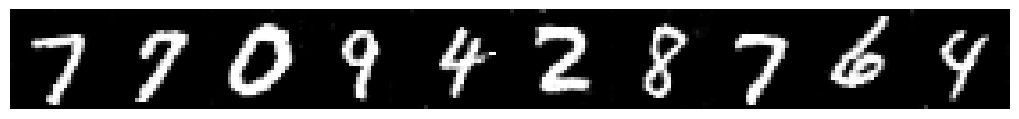

In [390]:
numbers = np.random.randint(10, size=10)
write_numbers(numbers)

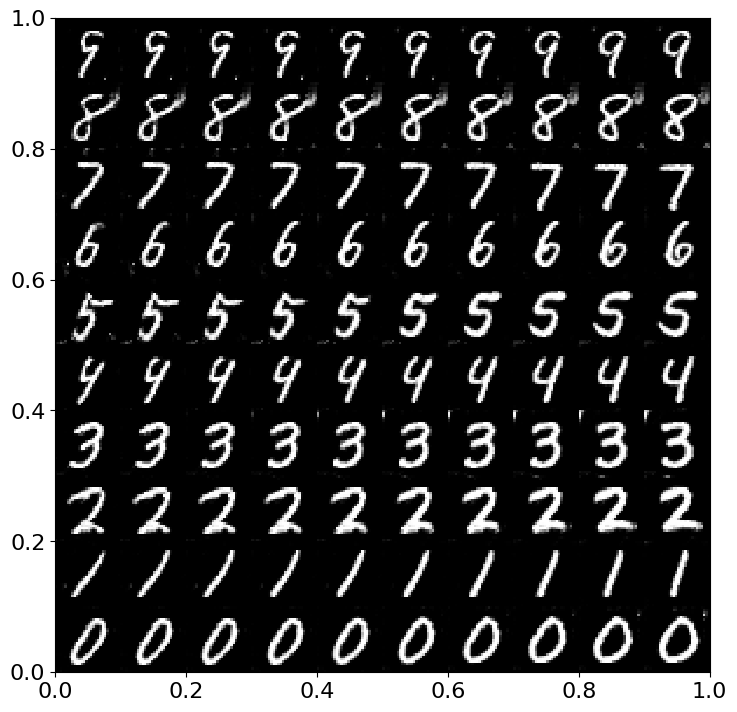

In [393]:
n = 10
interpolation_range = (0.0, 1.0)
z1 = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
z2 = generate_random_noise_in_range((1, latent_dim), r1=-1, r2=1, dtype=dtype, device=device)
r1_samples = np.linspace(*interpolation_range, num=n)
r2_samples = np.linspace(*interpolation_range, num=n)
plt.figure(figsize=(20,8.5))
w = 28
img = np.zeros((n*w, n*w))
for i, r1 in enumerate(r1_samples):
    for j, r2 in enumerate(r2_samples):
        z_interpolate = torch.mul(z1, r1) + torch.mul(z2, 1 - r2)
        labels = torch.cuda.LongTensor([i])
        with torch.no_grad():
          generated_image = generator(z_interpolate, labels).cpu().view(28, 28)
        img[(n - 1 - i) * w : (n - 1 - i + 1) * w, j * w : (j + 1) * w] = generated_image
plt.imshow(img, extent=[*interpolation_range, *interpolation_range], cmap='gist_gray')